In [53]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor as xgb
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import fancyimpute
from IPython.display import HTML, display, clear_output
%matplotlib inline
sns.set(rc={'figure.figsize':(18,6)})

/home/firehawk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TrainDataPath = 'train.csv'
DemogDataPath = 'demog.csv'
subDataPath = 'submission.csv'

# Loading the Training and Test Dataset
TrainData = pd.read_csv(TrainDataPath)
DemogData = pd.read_csv(DemogDataPath)
SubData = pd.read_csv(subDataPath)

In [3]:
print("Training Dataset Shape:")
print(TrainData.shape)
print("\n")
print("Training Dataset Columns/Features:")
print(TrainData.dtypes)
TrainData.head()

Training Dataset Shape:
(37186, 12)


Training Dataset Columns/Features:
HCP_ID             int64
RL               float64
P2P              float64
OLV              float64
RR               float64
DRT              float64
DMS              float64
OLA              float64
DEM              float64
Region            object
Value             object
Speciality_ID      int64
dtype: object


,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999


In [4]:
print("Demog Dataset Shape:")
print(DemogData.shape)
print("\n")
print("Demog Dataset Columns/Features:")
print(DemogData.dtypes)
DemogData.head()

Demog Dataset Shape:
(46485, 3)


Demog Dataset Columns/Features:
HCP_ID     int64
gender    object
Age        int64
dtype: object


,HCP_ID,gender,Age
0,14586,FEMALE,34
1,46157,MALE,34
2,16600,MALE,34
3,16601,MALE,33
4,16602,FEMALE,33


In [5]:
print("Sub Dataset Shape:")
print(SubData.shape)
print("\n")
print("Sub Dataset Columns/Features:")
print(SubData.dtypes)
SubData.head()

Sub Dataset Shape:
(37186, 9)


Sub Dataset Columns/Features:
HCP_ID      int64
RL        float64
P2P       float64
OLV       float64
RR        float64
DRT       float64
DMS       float64
OLA       float64
DEM       float64
dtype: object


,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009


In [6]:
# checking missing data percentage in train data
total = TrainData.isnull().sum().sort_values(ascending = False)
percent = (TrainData.isnull().sum()/TrainData.isnull().count()*100).sort_values(ascending = False)
missing_TrainData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_TrainData.head(30)

,Total,Percent
P2P,29136,78.352068
OLV,17027,45.788738
OLA,11170,30.038186
DEM,11040,29.688592
RR,9648,25.945248
RL,4849,13.039854
DRT,4492,12.079815
DMS,4379,11.775937
Speciality_ID,0,0.000000
Value,0,0.000000


In [7]:
# checking missing data percentage in demog data
total = DemogData.isnull().sum().sort_values(ascending = False)
percent = (DemogData.isnull().sum()/DemogData.isnull().count()*100).sort_values(ascending = False)
missing_DemogData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_DemogData.head(30)

,Total,Percent
gender,31,0.066688
Age,0,0.000000
HCP_ID,0,0.000000


In [8]:
# checking missing data percentage in sub data
total = SubData.isnull().sum().sort_values(ascending = False)
percent = (SubData.isnull().sum()/SubData.isnull().count()*100).sort_values(ascending = False)
missing_SubData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_SubData.head(30)

,Total,Percent
P2P,29136,78.352068
OLV,17027,45.788738
OLA,11170,30.038186
DEM,11040,29.688592
RR,9648,25.945248
RL,4849,13.039854
DRT,4492,12.079815
DMS,4379,11.775937
HCP_ID,0,0.000000


In [9]:
TrainData.describe()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Speciality_ID
count,37186.000000,32337.000000,8050.000000,20159.000000,27538.000000,32694.000000,32807.000000,26016.000000,26146.000000,37186.000000
mean,27910.118297,0.601944,0.189566,0.155577,0.221124,0.036384,0.118864,0.192901,0.072392,193459.336094
std,10741.107350,0.184662,0.179546,0.191303,0.197190,0.095047,0.174413,0.113425,0.088854,113903.409766
min,9304.000000,0.022727,0.024893,0.017238,0.002376,0.000000,0.000000,0.000000,0.000000,18766.000000
25%,18612.250000,0.491228,0.068771,0.034476,0.068164,0.000000,0.010101,0.109769,0.000000,155443.000000
50%,27910.500000,0.630435,0.137542,0.086190,0.163704,0.000000,0.058642,0.185038,0.046951,155443.000000
75%,37210.750000,0.740000,0.208524,0.189618,0.313554,0.022222,0.145299,0.263858,0.104650,155443.000000
max,46513.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,569454.000000


In [10]:
SubData.describe()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM
count,37186.000000,32337.000000,8050.000000,20159.000000,27538.000000,32694.000000,32807.000000,26016.000000,26146.000000
mean,27910.118297,0.601944,0.189566,0.155577,0.221124,0.036384,0.118864,0.192901,0.072392
std,10741.107350,0.184662,0.179546,0.191303,0.197190,0.095047,0.174413,0.113425,0.088854
min,9304.000000,0.022727,0.024893,0.017238,0.002376,0.000000,0.000000,0.000000,0.000000
25%,18612.250000,0.491228,0.068771,0.034476,0.068164,0.000000,0.010101,0.109769,0.000000
50%,27910.500000,0.630435,0.137542,0.086190,0.163704,0.000000,0.058642,0.185038,0.046951
75%,37210.750000,0.740000,0.208524,0.189618,0.313554,0.022222,0.145299,0.263858,0.104650
max,46513.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# This function return the multivariable analysis of two dataframe in term of unique column values
def train_test_data_check(train_df, test_df, cols=None, use_all_cols=True):
    if cols == None:
        if use_all_cols:
            train_cols = set(train_df.columns)
            test_cols = set(test_df.columns)
            cols = train_cols.intersection(test_cols)
        else:
            train_cols = set(train_df.select_dtypes(['object', 'category']).columns)
            test_cols = set(test_df.select_dtypes(['object', 'category']).columns)
            cols = train_cols.intersection(test_cols)
        
    for i, col in enumerate(cols):
        display(HTML('<h3><font id="'+ col + '-ttdc' + '" color="blue">' + str(i+1) + ') ' + col + '</font></h3>'))
        print("Datatype : " + str(train_df[col].dtype) )
        print(str(train_df[col].dropna().nunique()) + " unique " + col  + " in Train dataset")
        print(str(test_df[col].dropna().nunique()) + " unique " + col  + " in Test dataset")
        extra = len(set(test_df[col].dropna().unique()) - set(train_df[col].dropna().unique()))
        print(str(extra) + " extra " + col + " in Test dataset")
        if extra == 0:
            display(HTML('<h5><font color="green"> All values present in Test dataset also present in Train dataset for column ' + col + '</font></h5>'))
        else:
            display(HTML('<h5><font color="green">' + str(extra) + ' ' +  col + ' are not present in Train dataset which are in Test dataset</font></h5>'))

In [12]:
train_test_data_check(TrainData, SubData)

Datatype : float64
1589 unique RL in Train dataset
1589 unique RL in Test dataset
0 extra RL in Test dataset


Datatype : float64
25310 unique OLA in Train dataset
25310 unique OLA in Test dataset
0 extra OLA in Test dataset


Datatype : float64
392 unique OLV in Train dataset
392 unique OLV in Test dataset
0 extra OLV in Test dataset


Datatype : int64
37186 unique HCP_ID in Train dataset
37186 unique HCP_ID in Test dataset
0 extra HCP_ID in Test dataset


Datatype : float64
147 unique P2P in Train dataset
147 unique P2P in Test dataset
0 extra P2P in Test dataset


Datatype : float64
700 unique RR in Train dataset
700 unique RR in Test dataset
0 extra RR in Test dataset


Datatype : float64
19381 unique DEM in Train dataset
19381 unique DEM in Test dataset
0 extra DEM in Test dataset


Datatype : float64
792 unique DRT in Train dataset
792 unique DRT in Test dataset
0 extra DRT in Test dataset


Datatype : float64
6245 unique DMS in Train dataset
6245 unique DMS in Test dataset
0 extra DMS in Test dataset


In [13]:
train_test_data_check(TrainData, DemogData)

Datatype : int64
37186 unique HCP_ID in Train dataset
46485 unique HCP_ID in Test dataset
9299 extra HCP_ID in Test dataset


### Here we can see that we have 9299 more HCP_ID in demog data than the Train Data

In [14]:
train_test_data_check(SubData, DemogData)

Datatype : int64
37186 unique HCP_ID in Train dataset
46485 unique HCP_ID in Test dataset
9299 extra HCP_ID in Test dataset


# VISUALIZATIONS

### We cannot find more correlation

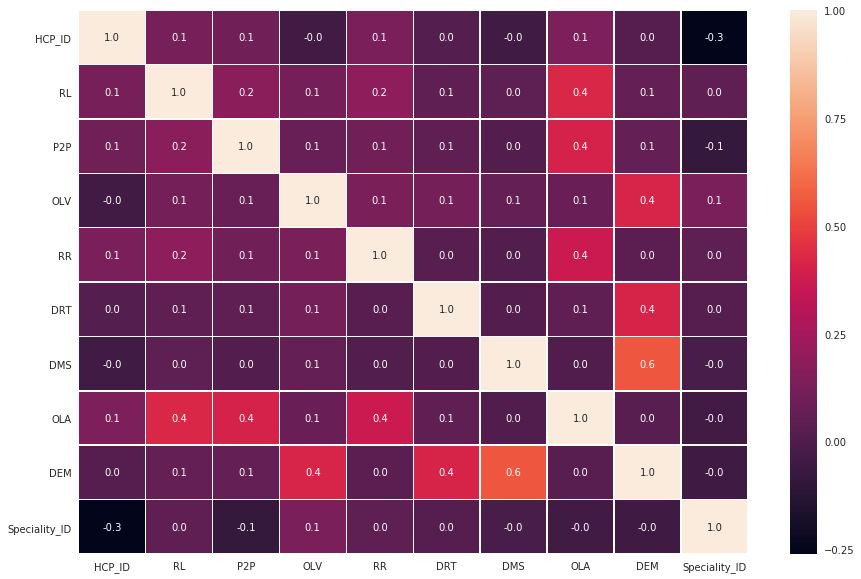

In [15]:
# TRAIN DATA`
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(TrainData.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

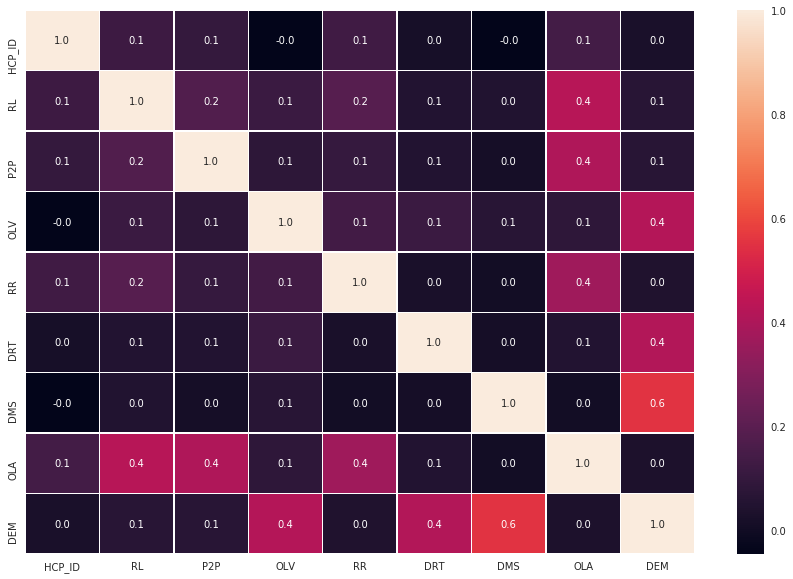

In [16]:
# Sub DATA`
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(SubData.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

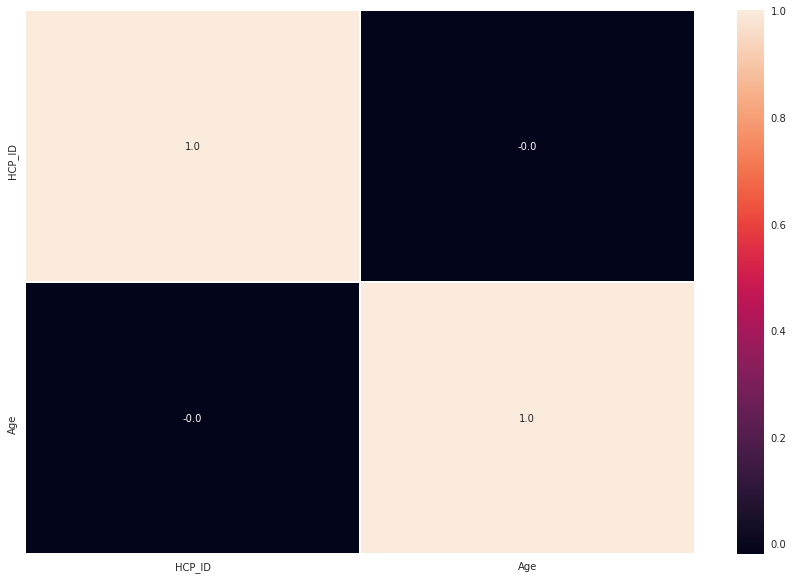

In [17]:
# Demog DATA`
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(DemogData.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [18]:
# This function returns the count plot of a column with percentage of each class
def plot_bar_counts_categorical(data_se, title, figsize, sort_by_counts=False):
    info = data_se.value_counts()
    info_norm = data_se.value_counts(normalize=True)
    categories = info.index.values
    counts = info.values
    counts_norm = info_norm.values
    fig, ax = plt.subplots(figsize=figsize)
    if data_se.dtype in ['object']:
        if sort_by_counts == False:
            inds = categories.argsort()
            counts = counts[inds]
            counts_norm = counts_norm[inds]
            categories = categories[inds]
        ax = sns.barplot(counts, categories, orient = "h", ax=ax)
        ax.set(xlabel="count", ylabel=data_se.name)
        ax.set_title("Distribution of " + title)
        for n, da in enumerate(counts):
            ax.text(da, n, str(da)+ ",  " + str(round(counts_norm[n]*100,2)) + " %", fontsize=10, va='center')
    else:
        inds = categories.argsort()
        counts_sorted = counts[inds]
        counts_norm_sorted = counts_norm[inds]
        ax = sns.barplot(categories, counts, orient = "v", ax=ax)
        ax.set(xlabel=data_se.name, ylabel='count')
        ax.set_title("Distribution of " + title)
        for n, da in enumerate(counts_sorted):
            ax.text(n, da, str(da)+ ",  " + str(round(counts_norm_sorted[n]*100,2)) + " %", fontsize=10, ha='center')

# DEMOG VISUAL

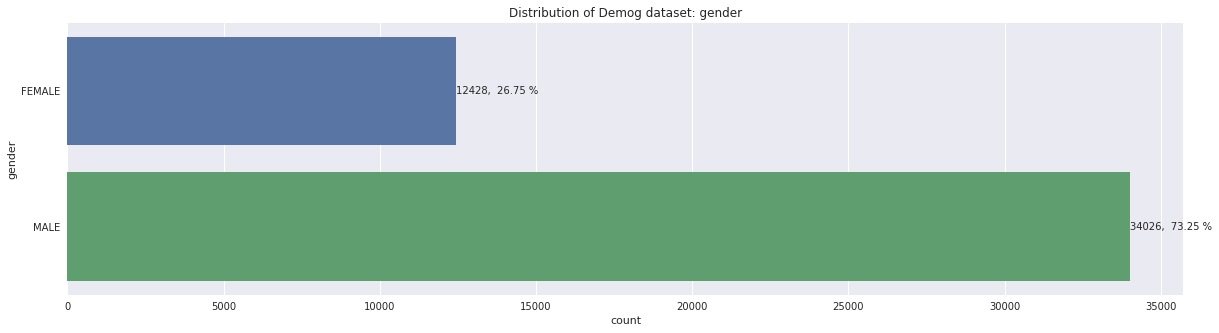

In [20]:
plot_bar_counts_categorical(DemogData['gender'], 'Demog dataset: gender', (20,5))

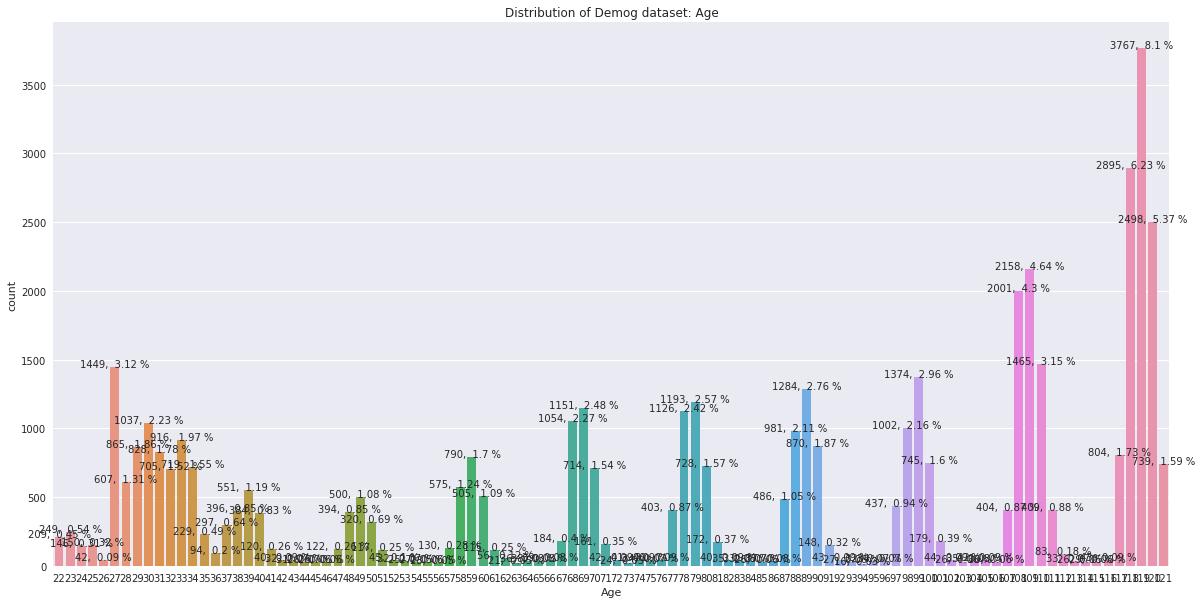

In [21]:
plot_bar_counts_categorical(DemogData['Age'], 'Demog dataset: Age', (20,10))

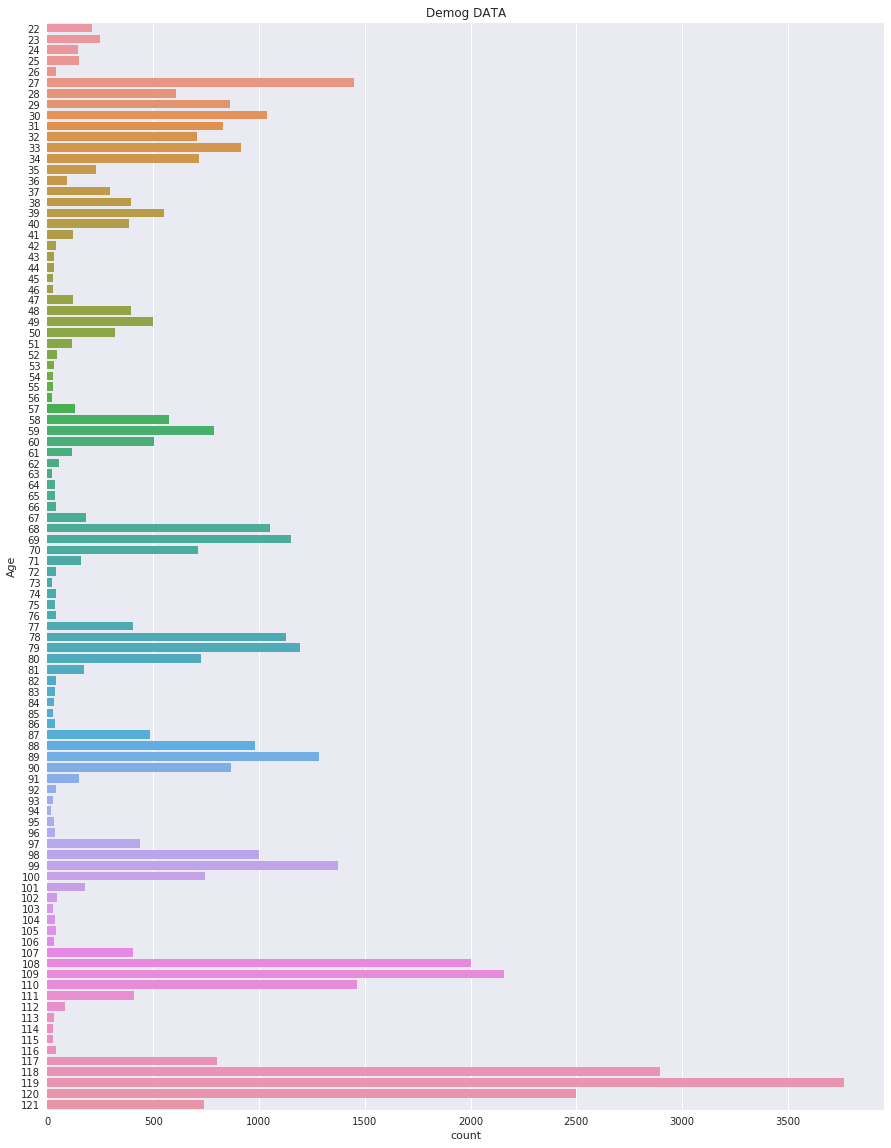

In [22]:
plt.figure(figsize=(15, 20))
sns.countplot(y=DemogData['Age'])
plt.title('Demog DATA')
plt.xlabel('count')
plt.ylabel('Age')
plt.show()

# Train Data

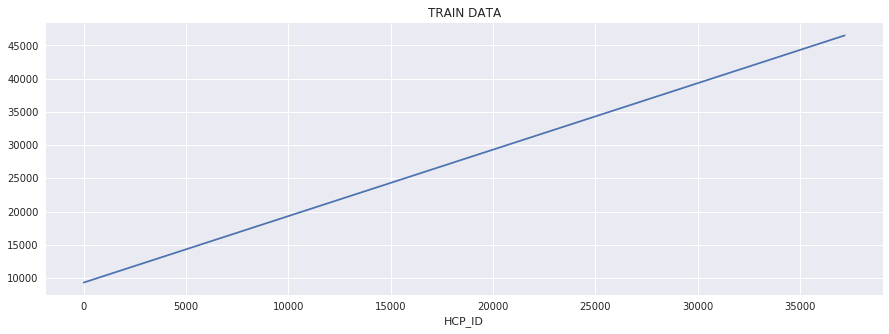

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['HCP_ID'])
plt.title('TRAIN DATA')
plt.xlabel('HCP_ID')
plt.show()
# This feature is of no use as it is growing linear it will not help model to improve

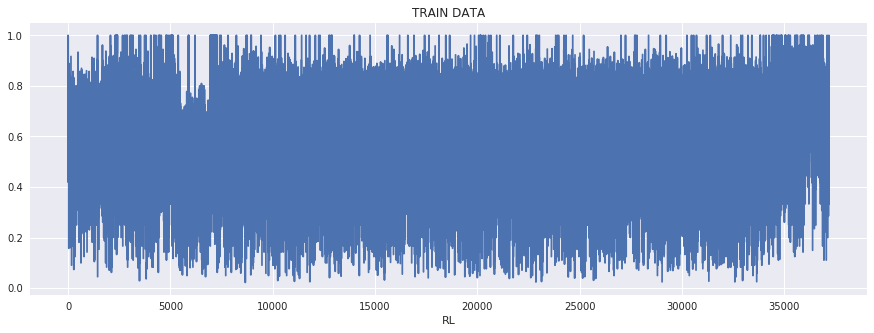

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['RL'])
plt.title('TRAIN DATA')
plt.xlabel('RL')
plt.show()
# Fluctuating value of RL column in Train Data

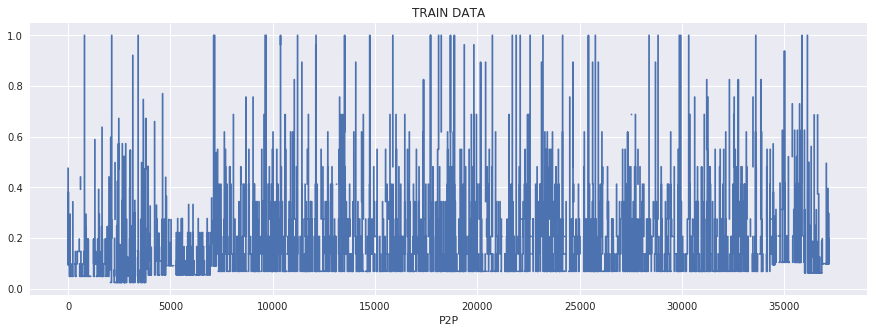

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['P2P'])
plt.title('TRAIN DATA')
plt.xlabel('P2P')
plt.show()
# Fluctuating value of P2P column in Train Data

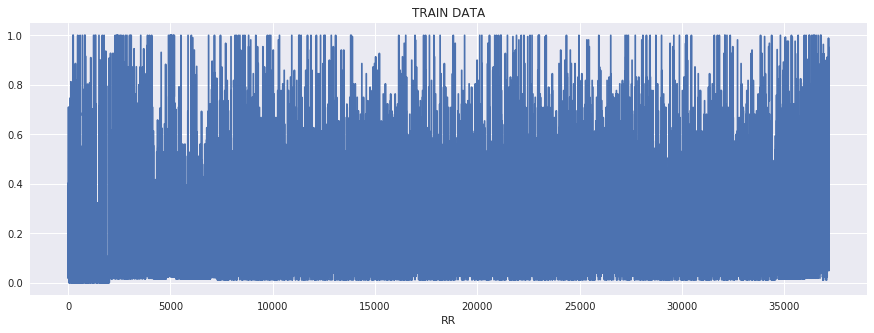

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['RR'])
plt.title('TRAIN DATA')
plt.xlabel('RR')
plt.show()

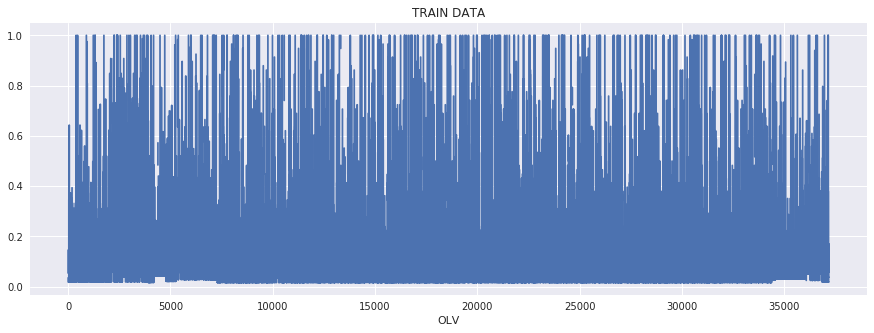

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['OLV'])
plt.title('TRAIN DATA')
plt.xlabel('OLV')
plt.show()

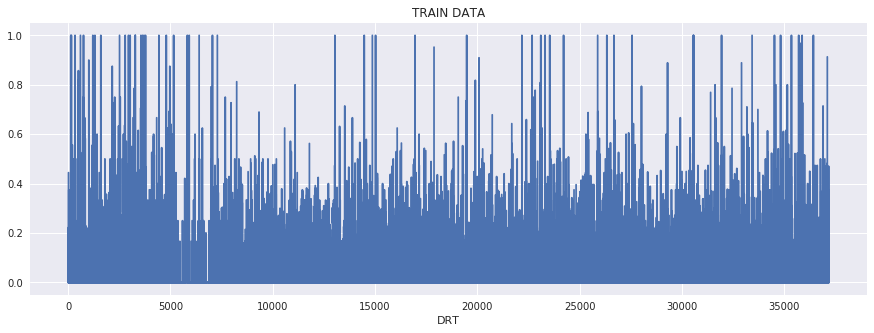

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['DRT'])
plt.title('TRAIN DATA')
plt.xlabel('DRT')
plt.show()

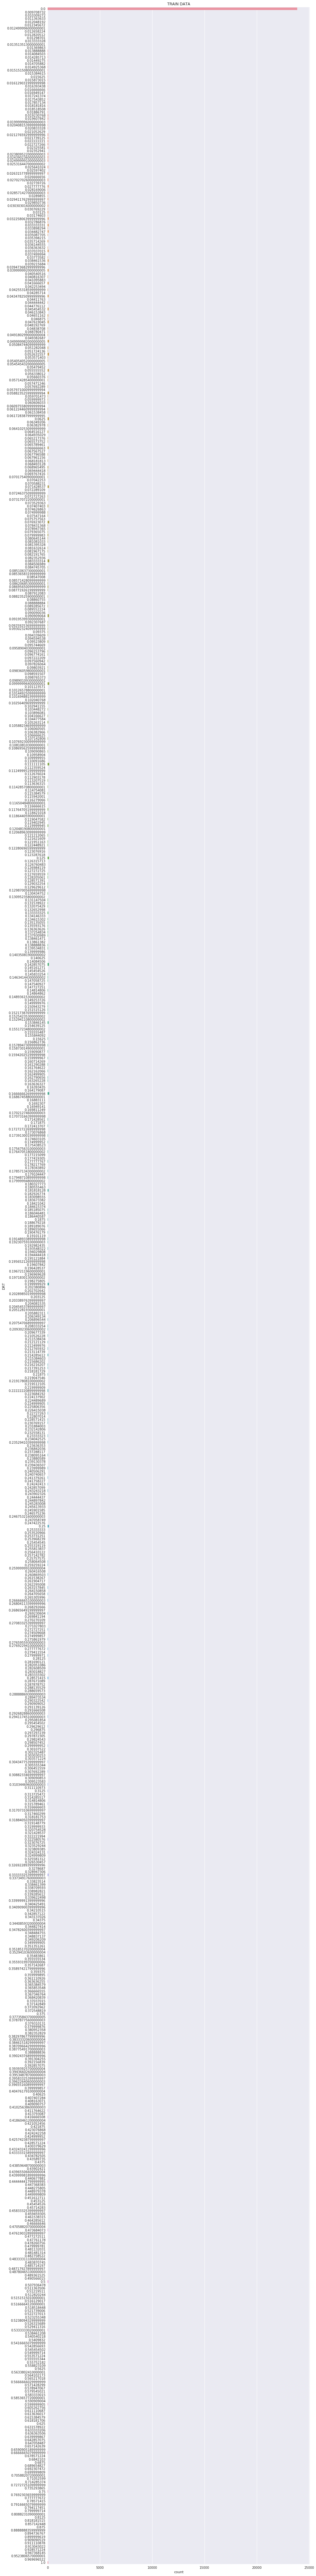

In [52]:
plt.figure(figsize=(15, 150))
sns.countplot(y=TrainData['DRT'])
plt.title('TRAIN DATA')
plt.show()
# Max value in DRT are of the value 0.0

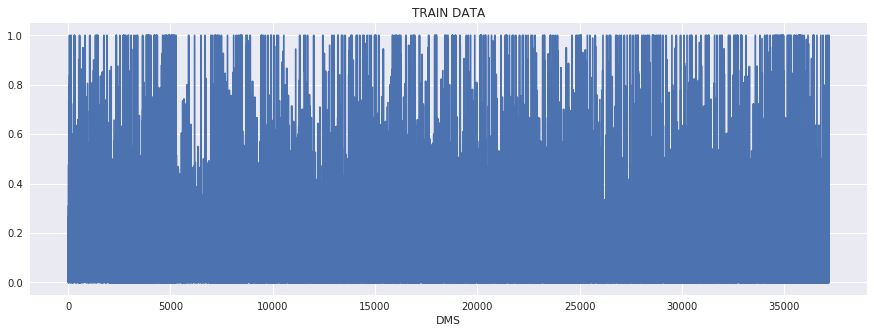

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['DMS'])
plt.title('TRAIN DATA')
plt.xlabel('DMS')
plt.show()

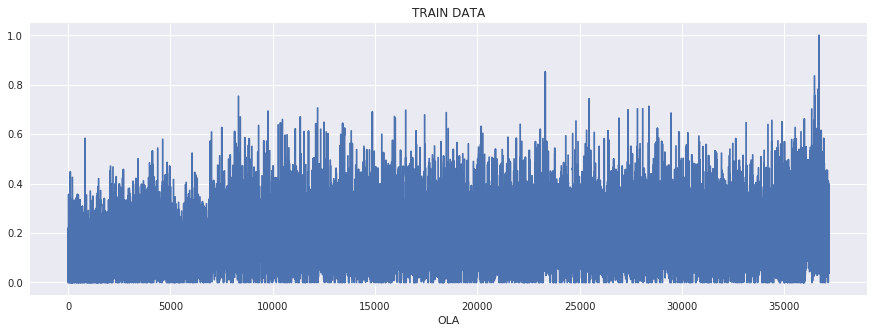

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['OLA'])
plt.title('TRAIN DATA')
plt.xlabel('OLA')
plt.show()

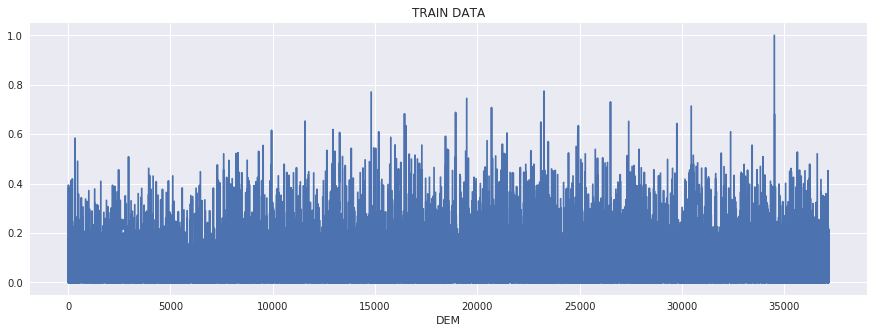

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(TrainData['DEM'])
plt.title('TRAIN DATA')
plt.xlabel('DEM')
plt.show()

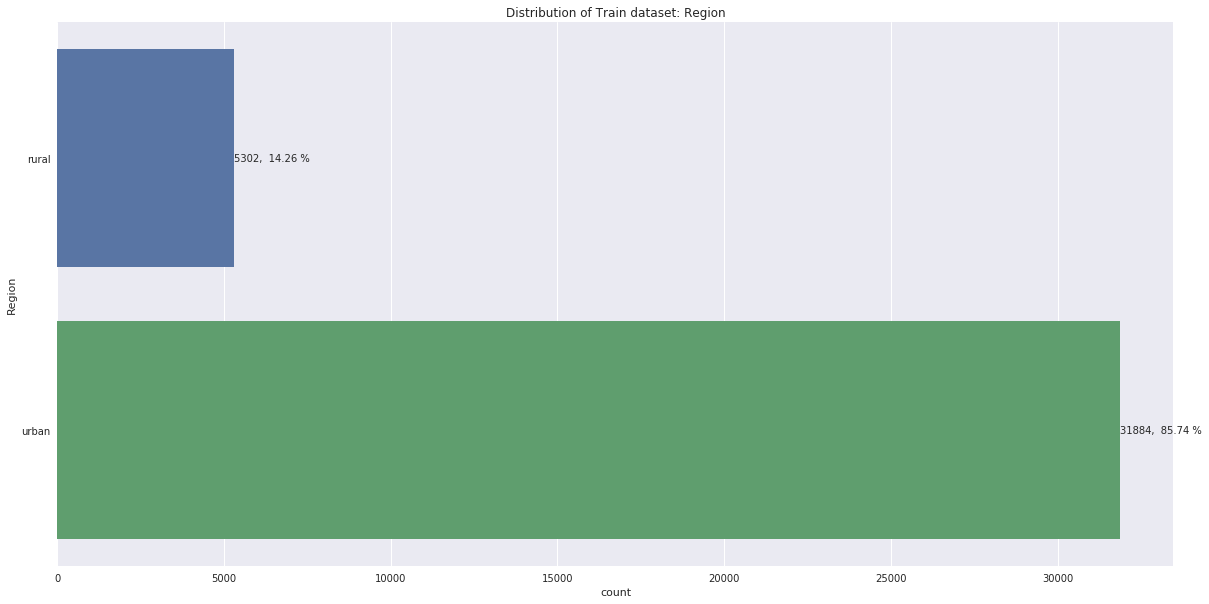

In [32]:
plot_bar_counts_categorical(TrainData['Region'], 'Train dataset: Region', (20,10))
# Mostly the Region is Urban

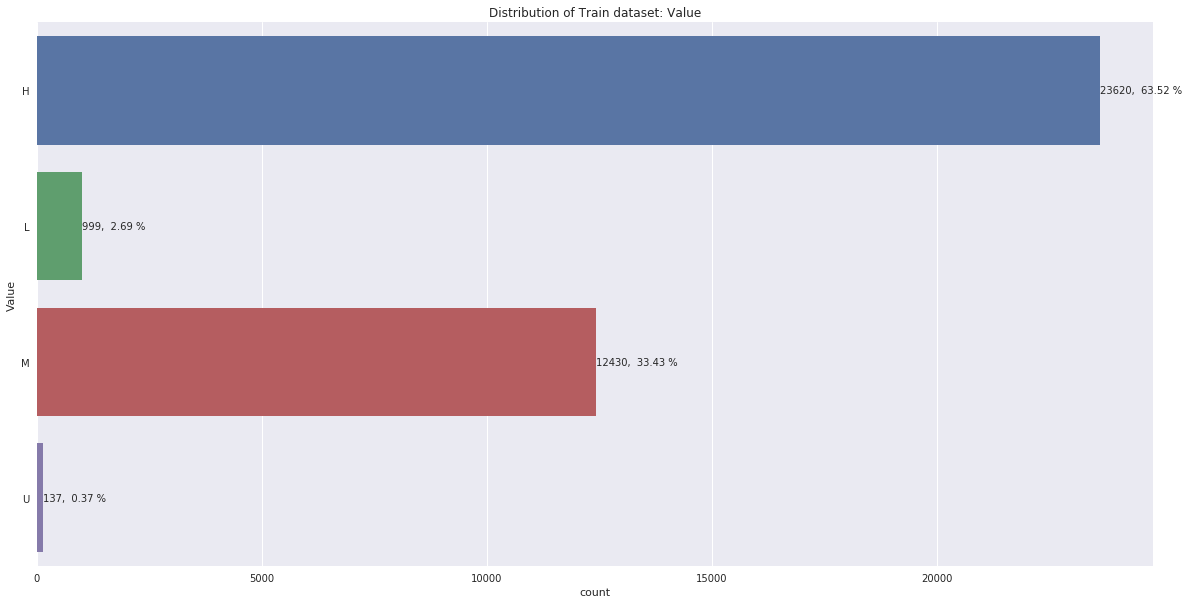

In [33]:
plot_bar_counts_categorical(TrainData['Value'], 'Train dataset: Value', (20,10))
# Mostly the value is HIGH

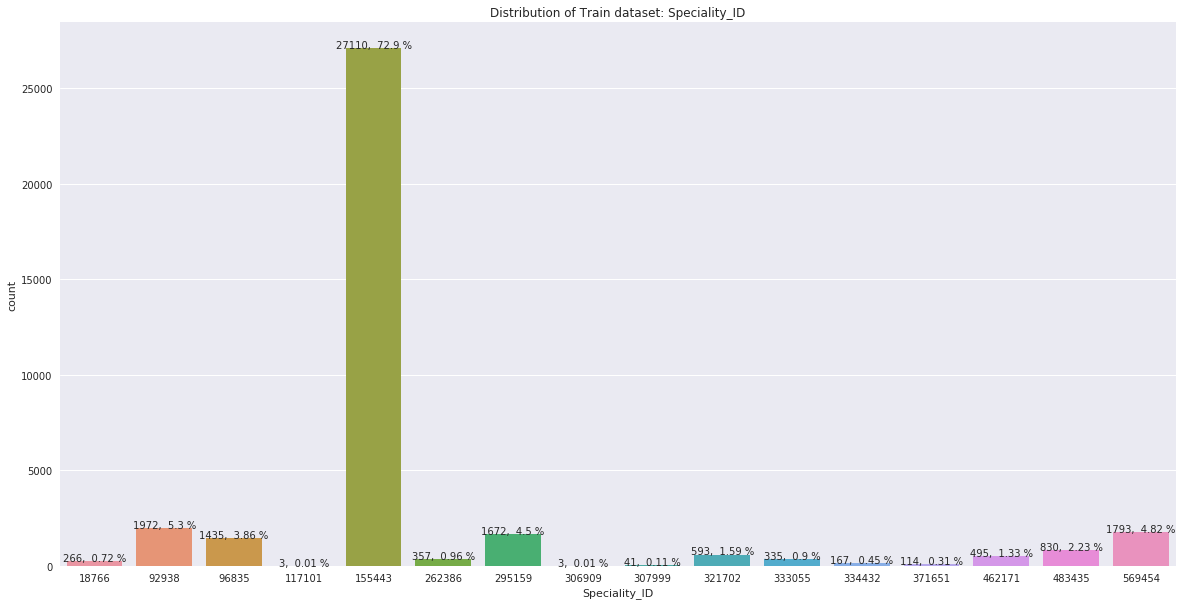

In [34]:
plot_bar_counts_categorical(TrainData['Speciality_ID'], 'Train dataset: Speciality_ID', (20,10))

# OUTLIER IN TRAIN DATA

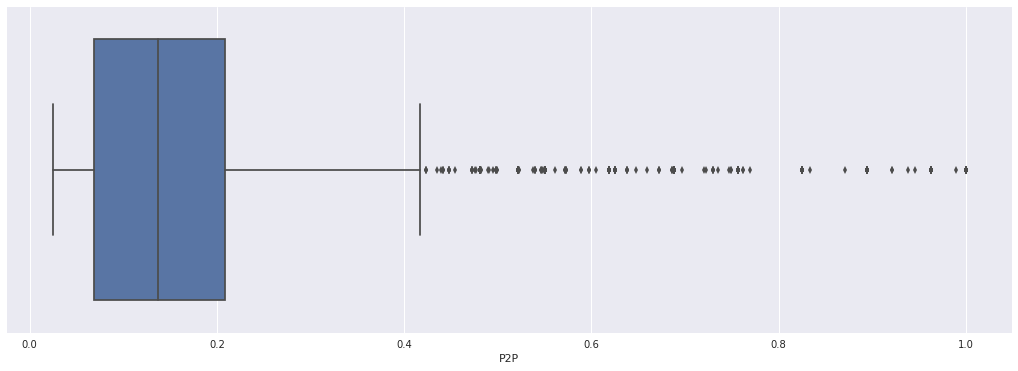

In [35]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["P2P"])
plt.show()

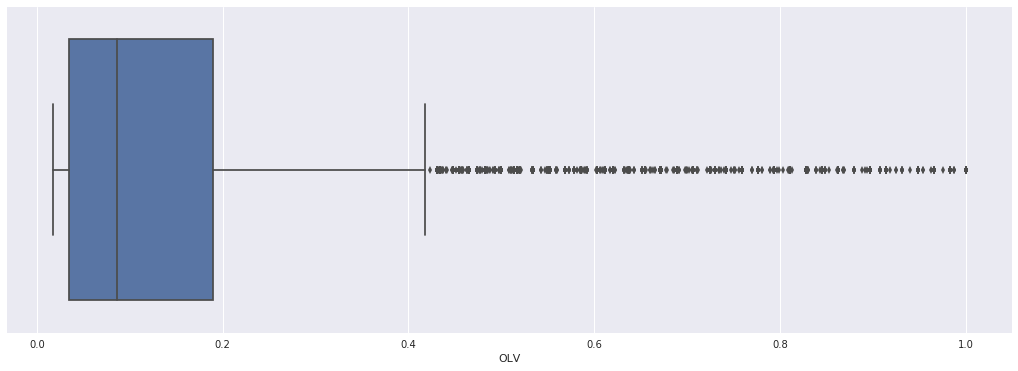

In [36]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["OLV"])
plt.show()

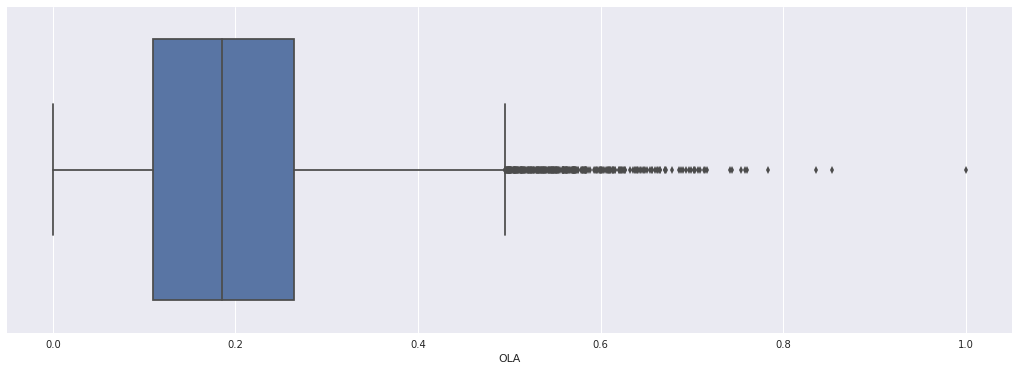

In [37]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["OLA"])
plt.show()

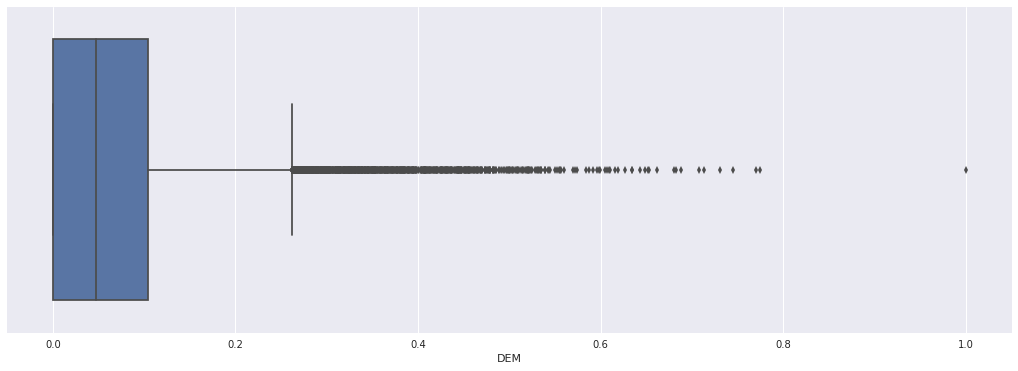

In [38]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["DEM"])
plt.show()

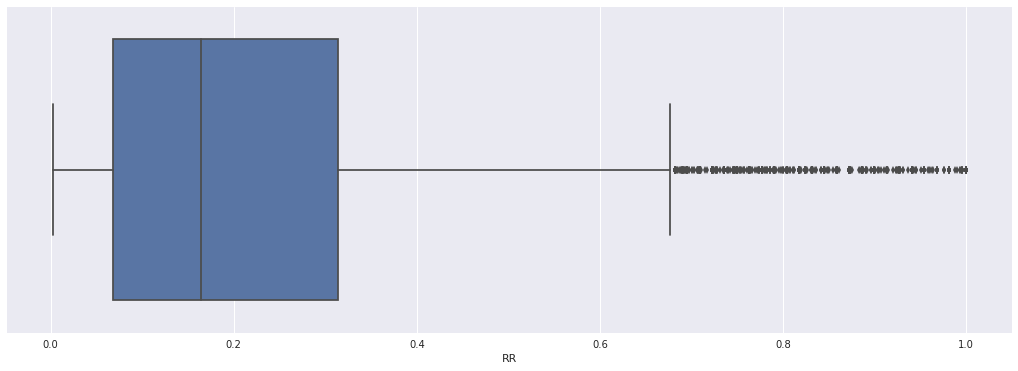

In [39]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["RR"])
plt.show()

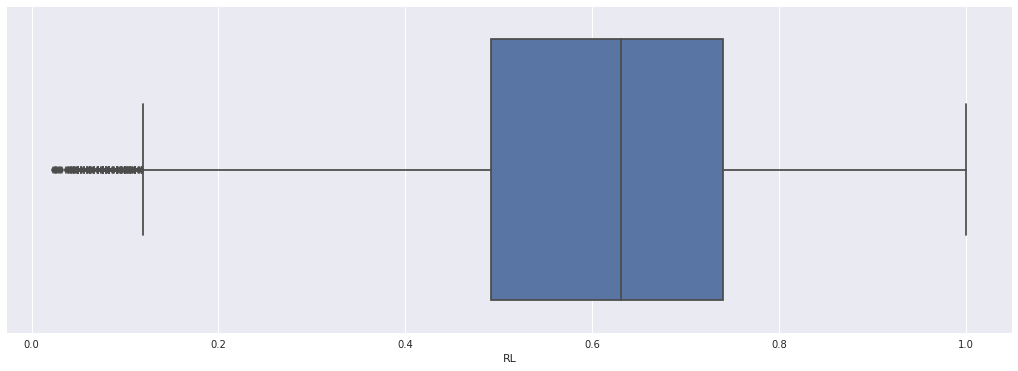

In [40]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["RL"])
plt.show()

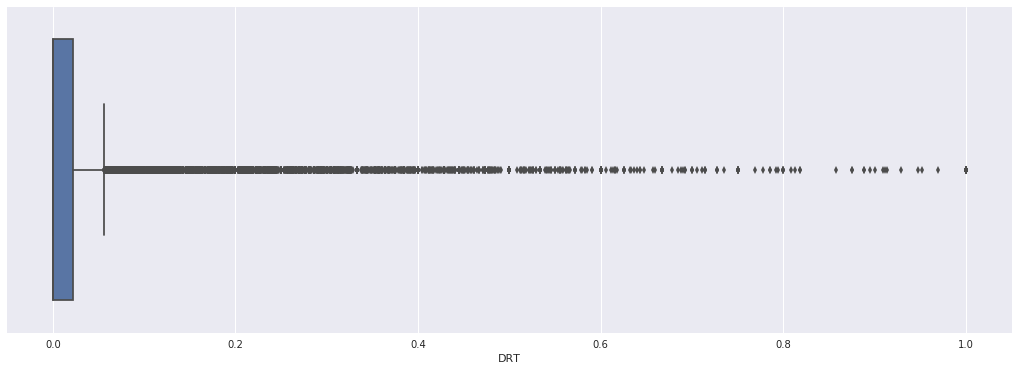

In [41]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["DRT"])
plt.show()

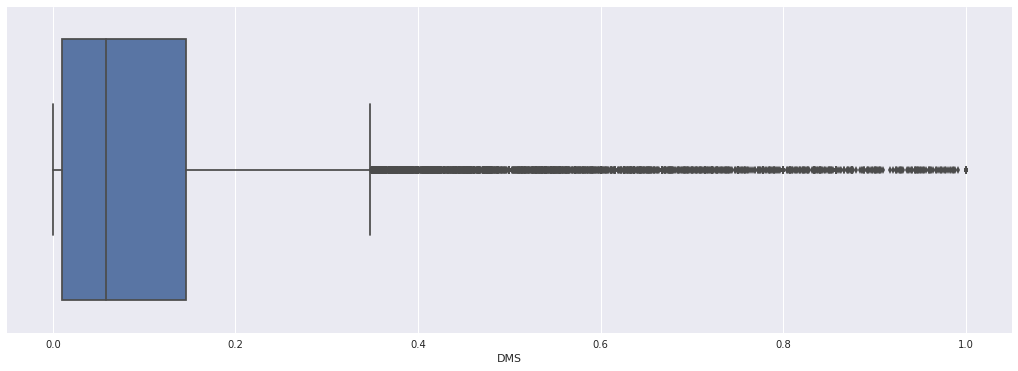

In [42]:
plt.figure(figsize=(18, 6))
sns.boxplot(TrainData["DMS"])
plt.show()

# SOME FINDINGS

In [43]:
# THERE ARE NO COLUMNS WITH ALL NULL VALUE
TrainData[TrainData['P2P'].notnull() & TrainData['OLV'].notnull() & TrainData['OLA'].notnull() & TrainData['DEM'].notnull() & TrainData['RR'].notnull() & TrainData['RL'].notnull() & TrainData['DRT'].notnull() & TrainData['DMS'].notnull()]

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID


# MODEL MERGE

In [68]:
result = pd.merge(TrainData, DemogData, on='HCP_ID')

In [69]:
result.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,120
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,29
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,32
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,60
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,110


In [70]:
# checking missing data percentage in train data
total = result.isnull().sum().sort_values(ascending = False)
percent = (result.isnull().sum()/result.isnull().count()*100).sort_values(ascending = False)
missing_result  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_result.head(30)

,Total,Percent
P2P,29136,78.352068
OLV,17027,45.788738
OLA,11170,30.038186
DEM,11040,29.688592
RR,9648,25.945248
RL,4849,13.039854
DRT,4492,12.079815
DMS,4379,11.775937
gender,28,0.075297
Age,0,0.000000


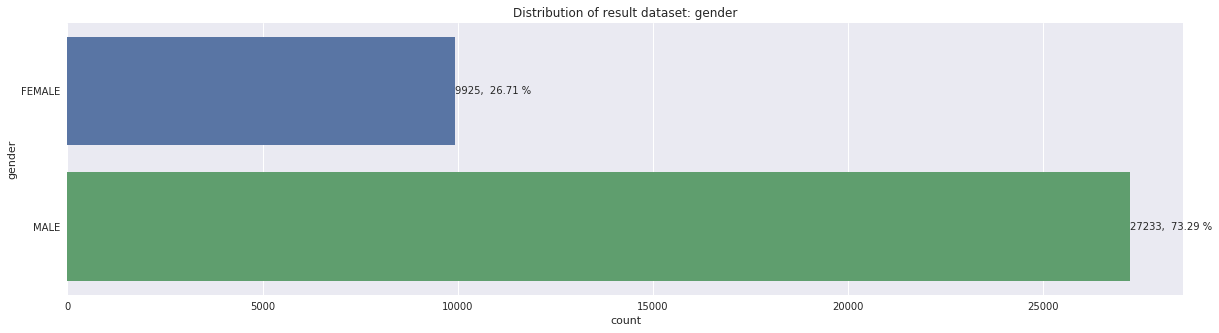

In [47]:
plot_bar_counts_categorical(result['gender'], 'result dataset: gender', (20,5))

In [71]:
result.loc[result["gender"].isnull(),"gender"] = "MALE"

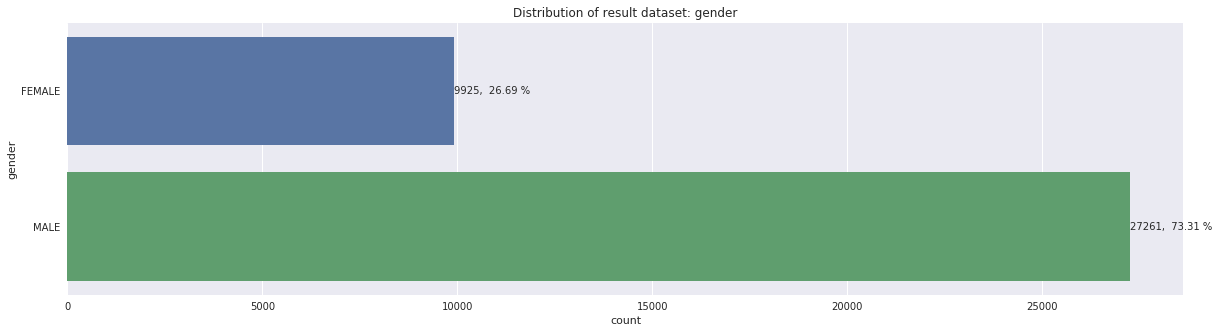

In [49]:
plot_bar_counts_categorical(result['gender'], 'result dataset: gender', (20,5))

# LABEL ENCODING

In [72]:
result.loc[result["Region"] == "urban","Region"] = 0
result.loc[result["Region"] == "rural","Region"] = 1

result.loc[result["Value"] == "U","Value"] = -1
result.loc[result["Value"] == "L","Value"] = 0
result.loc[result["Value"] == "M","Value"] = 1
result.loc[result["Value"] == "H","Value"] = 2

result.loc[result["gender"] == "MALE","gender"] = 0
result.loc[result["gender"] == "FEMALE","gender"] = 1

result.loc[result["Speciality_ID"] == 18766,"Speciality_ID"] = 0
result.loc[result["Speciality_ID"] == 92938,"Speciality_ID"] = 1
result.loc[result["Speciality_ID"] == 96835,"Speciality_ID"] = 2
result.loc[result["Speciality_ID"] == 117101,"Speciality_ID"] = 3
result.loc[result["Speciality_ID"] == 155443,"Speciality_ID"] = 4
result.loc[result["Speciality_ID"] == 262386,"Speciality_ID"] = 5
result.loc[result["Speciality_ID"] == 295159,"Speciality_ID"] = 6
result.loc[result["Speciality_ID"] == 306909,"Speciality_ID"] = 7
result.loc[result["Speciality_ID"] == 307999,"Speciality_ID"] = 8
result.loc[result["Speciality_ID"] == 321702,"Speciality_ID"] = 9
result.loc[result["Speciality_ID"] == 333055,"Speciality_ID"] = 10
result.loc[result["Speciality_ID"] == 334432,"Speciality_ID"] = 11
result.loc[result["Speciality_ID"] == 371651,"Speciality_ID"] = 12
result.loc[result["Speciality_ID"] == 462171,"Speciality_ID"] = 13
result.loc[result["Speciality_ID"] == 483435,"Speciality_ID"] = 14
result.loc[result["Speciality_ID"] == 569454,"Speciality_ID"] = 15

In [73]:
X_tr = result.drop(["HCP_ID","P2P","OLV","OLA","Region","Value","Speciality_ID","gender","Age"],axis=1)
X_tr.head()

,RL,RR,DRT,DMS,DEM
0,0.645833,NaN,0.0,0.169355,0.004458
1,0.419355,0.115167,0.0,0.012195,0.000000
2,1.000000,0.134362,0.0,0.149254,0.113179
3,0.564102,0.076778,NaN,0.138889,0.002574
4,0.584906,0.383891,0.0,0.198198,0.044009


In [74]:
X_tr.shape

(37186, 5)

### While going through the dataset I observed that there is a certain pattern which repeats in these five columns RL, RR, DRT, DMS, DEM i.e. we can predict the null values of any one if we observe the other four columns 

### That why we are I thought of using KNN imputer with k=4

In [77]:
model = fancyimpute.KNN(k=4)
x1 = model.complete(X_tr.loc[:9999,])
df1 = pd.DataFrame(x1)
df1.columns = X_tr.columns

model = fancyimpute.KNN(k=4)
x2 = model.complete(X_tr.loc[10000:19999,])
df2 = pd.DataFrame(x2)
df2.columns = X_tr.columns

model = fancyimpute.KNN(k=4)
x3 = model.complete(X_tr.loc[20000:29999,])
df3 = pd.DataFrame(x3)
df3.columns = X_tr.columns

model = fancyimpute.KNN(k=4)
x4 = model.complete(X_tr.loc[30000:,])
df4 = pd.DataFrame(x4)
df4.columns = X_tr.columns

Imputing row 1/10000 with 1 missing, elapsed time: 17.859
Imputing row 101/10000 with 1 missing, elapsed time: 17.866
Imputing row 201/10000 with 3 missing, elapsed time: 17.874
Imputing row 301/10000 with 2 missing, elapsed time: 17.881
Imputing row 401/10000 with 0 missing, elapsed time: 17.888
Imputing row 501/10000 with 0 missing, elapsed time: 17.895
Imputing row 601/10000 with 0 missing, elapsed time: 17.902
Imputing row 701/10000 with 0 missing, elapsed time: 17.910
Imputing row 801/10000 with 2 missing, elapsed time: 17.917
Imputing row 901/10000 with 0 missing, elapsed time: 17.924
Imputing row 1001/10000 with 0 missing, elapsed time: 17.932
Imputing row 1101/10000 with 1 missing, elapsed time: 17.939
Imputing row 1201/10000 with 0 missing, elapsed time: 17.946
Imputing row 1301/10000 with 1 missing, elapsed time: 17.953
Imputing row 1401/10000 with 0 missing, elapsed time: 17.960
Imputing row 1501/10000 with 2 missing, elapsed time: 17.967
Imputing row 1601/10000 with 1 missi

Imputing row 5101/10000 with 0 missing, elapsed time: 18.629
Imputing row 5201/10000 with 1 missing, elapsed time: 18.640
Imputing row 5301/10000 with 2 missing, elapsed time: 18.651
Imputing row 5401/10000 with 0 missing, elapsed time: 18.662
Imputing row 5501/10000 with 0 missing, elapsed time: 18.670
Imputing row 5601/10000 with 0 missing, elapsed time: 18.677
Imputing row 5701/10000 with 1 missing, elapsed time: 18.684
Imputing row 5801/10000 with 2 missing, elapsed time: 18.693
Imputing row 5901/10000 with 1 missing, elapsed time: 18.702
Imputing row 6001/10000 with 0 missing, elapsed time: 18.709
Imputing row 6101/10000 with 1 missing, elapsed time: 18.716
Imputing row 6201/10000 with 1 missing, elapsed time: 18.723
Imputing row 6301/10000 with 1 missing, elapsed time: 18.731
Imputing row 6401/10000 with 1 missing, elapsed time: 18.739
Imputing row 6501/10000 with 0 missing, elapsed time: 18.746
Imputing row 6601/10000 with 0 missing, elapsed time: 18.752
Imputing row 6701/10000 

[KNN] Warning: 5/50000 still missing after imputation, replacing with 0
Imputing row 1/7186 with 1 missing, elapsed time: 8.900
Imputing row 101/7186 with 1 missing, elapsed time: 8.906
Imputing row 201/7186 with 1 missing, elapsed time: 8.912
Imputing row 301/7186 with 2 missing, elapsed time: 8.917
Imputing row 401/7186 with 1 missing, elapsed time: 8.922
Imputing row 501/7186 with 0 missing, elapsed time: 8.929
Imputing row 601/7186 with 1 missing, elapsed time: 8.934
Imputing row 701/7186 with 0 missing, elapsed time: 8.941
Imputing row 801/7186 with 1 missing, elapsed time: 8.947
Imputing row 901/7186 with 0 missing, elapsed time: 8.953
Imputing row 1001/7186 with 0 missing, elapsed time: 8.958
Imputing row 1101/7186 with 1 missing, elapsed time: 8.964
Imputing row 1201/7186 with 1 missing, elapsed time: 8.970
Imputing row 1301/7186 with 2 missing, elapsed time: 8.976
Imputing row 1401/7186 with 1 missing, elapsed time: 8.982
Imputing row 1501/7186 with 0 missing, elapsed time: 8.

In [78]:
df1=df1.append(df2).reset_index(drop=True)
df1=df1.append(df3).reset_index(drop=True)
df1=df1.append(df4).reset_index(drop=True)

In [79]:
df1.head()

,RL,RR,DRT,DMS,DEM
0,0.645833,0.178951,0.0,0.169355,0.004458
1,0.419355,0.115167,0.0,0.012195,0.000000
2,1.000000,0.134362,0.0,0.149254,0.113179
3,0.564102,0.076778,0.0,0.138889,0.002574
4,0.584906,0.383891,0.0,0.198198,0.044009


In [80]:
# checking missing data percentage in train data
total = df1.isnull().sum().sort_values(ascending = False)
percent = (df1.isnull().sum()/df1.isnull().count()*100).sort_values(ascending = False)
missing_DemogData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_DemogData.head(30)

,Total,Percent
DEM,0,0.0
DMS,0,0.0
DRT,0,0.0
RR,0,0.0
RL,0,0.0


In [81]:
result["RR"] = df1["RR"]
result["RL"] = df1["RL"]
result["DRT"] = df1["DRT"]
result["DMS"] = df1["DMS"]
result["DEM"] = df1["DEM"]

In [82]:
# checking missing data percentage in result data
total = result.isnull().sum().sort_values(ascending = False)
percent = (result.isnull().sum()/result.isnull().count()*100).sort_values(ascending = False)
missing_DemogData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_DemogData.head(30)

,Total,Percent
P2P,29136,78.352068
OLV,17027,45.788738
OLA,11170,30.038186
Age,0,0.000000
gender,0,0.000000
Speciality_ID,0,0.000000
Value,0,0.000000
Region,0,0.000000
DEM,0,0.000000
DMS,0,0.000000


### Now we have 3 more columns to predict i.e. P2P, OLA, OLV so we need some non linear model so I decide to use XGB Regressor

In [89]:
import catboost as cb

In [99]:
#reg = xgb(n_estimators=100,max_depth=3,seed=1729)
reg = cb.CatBoostRegressor(n_estimators=100, max_depth=3, random_state=1729, loss_function='RMSE')
categorical_features_indices = np.where(result.dtypes != np.float)[0]

In [100]:
X_tr = result.loc[result.OLA.notnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","OLA","Region","Value","Speciality_ID","gender","Age"]]
Y_tr = X_tr.OLA
X_tr = X_tr.drop(["OLA"],axis=1)
X_te = result.loc[result.OLA.isnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","Region","Value","Speciality_ID","gender","Age"]]
reg.fit(X_tr, Y_tr)
X_te["OLA"] = reg.predict(X_te)
X_tr = result.loc[result.OLA.notnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","OLA","Region","Value","Speciality_ID","gender","Age"]]
x = X_tr.append(X_te)
x_OLA = x.sort_values(by=["HCP_ID"])

0:	learn: 0.2185363	total: 8.34ms	remaining: 826ms
1:	learn: 0.2134713	total: 16.4ms	remaining: 804ms
2:	learn: 0.2085861	total: 24.4ms	remaining: 788ms
3:	learn: 0.2039444	total: 32.4ms	remaining: 777ms
4:	learn: 0.1994219	total: 40.6ms	remaining: 772ms
5:	learn: 0.1949854	total: 48.5ms	remaining: 760ms
6:	learn: 0.1908539	total: 56.5ms	remaining: 750ms
7:	learn: 0.1867549	total: 64.4ms	remaining: 740ms
8:	learn: 0.1828410	total: 72.3ms	remaining: 731ms
9:	learn: 0.1790087	total: 80.2ms	remaining: 722ms
10:	learn: 0.1754174	total: 88ms	remaining: 712ms
11:	learn: 0.1719783	total: 95.8ms	remaining: 703ms
12:	learn: 0.1686437	total: 104ms	remaining: 693ms
13:	learn: 0.1653709	total: 112ms	remaining: 686ms
14:	learn: 0.1622801	total: 119ms	remaining: 677ms
15:	learn: 0.1592760	total: 127ms	remaining: 668ms
16:	learn: 0.1564068	total: 135ms	remaining: 661ms
17:	learn: 0.1536461	total: 143ms	remaining: 653ms
18:	learn: 0.1510602	total: 151ms	remaining: 645ms
19:	learn: 0.1485062	total: 159

In [101]:
X_tr = result.loc[result.OLV.notnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","OLV","Region","Value","Speciality_ID","gender","Age"]]
Y_tr = X_tr.OLV
X_tr = X_tr.drop(["OLV"],axis=1)
X_te = result.loc[result.OLV.isnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","Region","Value","Speciality_ID","gender","Age"]]
reg.fit(X_tr, Y_tr)
X_te["OLV"] = reg.predict(X_te)
X_tr = result.loc[result.OLV.notnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","OLV","Region","Value","Speciality_ID","gender","Age"]]
x = X_tr.append(X_te)
x_OLV = x.sort_values(by=["HCP_ID"])

0:	learn: 0.2431462	total: 5.07ms	remaining: 502ms
1:	learn: 0.2398849	total: 10.3ms	remaining: 503ms
2:	learn: 0.2367596	total: 15.4ms	remaining: 499ms
3:	learn: 0.2337566	total: 21.5ms	remaining: 517ms
4:	learn: 0.2309968	total: 26.7ms	remaining: 508ms
5:	learn: 0.2283157	total: 31.9ms	remaining: 500ms
6:	learn: 0.2256829	total: 37.1ms	remaining: 493ms
7:	learn: 0.2231532	total: 44.3ms	remaining: 509ms
8:	learn: 0.2207998	total: 54ms	remaining: 546ms
9:	learn: 0.2185410	total: 59.1ms	remaining: 532ms
10:	learn: 0.2163189	total: 64.5ms	remaining: 522ms
11:	learn: 0.2142207	total: 69.6ms	remaining: 510ms
12:	learn: 0.2122454	total: 75ms	remaining: 502ms
13:	learn: 0.2104857	total: 79.9ms	remaining: 491ms
14:	learn: 0.2087680	total: 85.3ms	remaining: 483ms
15:	learn: 0.2070749	total: 90.3ms	remaining: 474ms
16:	learn: 0.2055508	total: 95.4ms	remaining: 466ms
17:	learn: 0.2040464	total: 101ms	remaining: 458ms
18:	learn: 0.2025722	total: 106ms	remaining: 451ms
19:	learn: 0.2012654	total: 

In [102]:
X_tr = result.loc[result.P2P.notnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","P2P","Region","Value","Speciality_ID","gender","Age"]]
Y_tr = X_tr.P2P
X_tr = X_tr.drop(["P2P"],axis=1)
X_te = result.loc[result.P2P.isnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","Region","Value","Speciality_ID","gender","Age"]]
reg.fit(X_tr, Y_tr)
X_te["P2P"] = reg.predict(X_te)
X_tr = result.loc[result.P2P.notnull(), ["HCP_ID","RL","DRT","RR","DEM","DMS","P2P","Region","Value","Speciality_ID","gender","Age"]]
x = X_tr.append(X_te)
x_P2P = x.sort_values(by=["HCP_ID"])

0:	learn: 0.2569364	total: 3.22ms	remaining: 319ms
1:	learn: 0.2529015	total: 6.14ms	remaining: 301ms
2:	learn: 0.2491447	total: 8.72ms	remaining: 282ms
3:	learn: 0.2455348	total: 11.5ms	remaining: 276ms
4:	learn: 0.2420473	total: 14.3ms	remaining: 272ms
5:	learn: 0.2387690	total: 17.1ms	remaining: 267ms
6:	learn: 0.2355543	total: 19.9ms	remaining: 265ms
7:	learn: 0.2325886	total: 22.5ms	remaining: 258ms
8:	learn: 0.2297554	total: 24.5ms	remaining: 248ms
9:	learn: 0.2270073	total: 27.3ms	remaining: 246ms
10:	learn: 0.2244018	total: 30ms	remaining: 243ms
11:	learn: 0.2218800	total: 32.8ms	remaining: 240ms
12:	learn: 0.2195364	total: 35.3ms	remaining: 236ms
13:	learn: 0.2172290	total: 38ms	remaining: 233ms
14:	learn: 0.2150466	total: 40.6ms	remaining: 230ms
15:	learn: 0.2129852	total: 43.6ms	remaining: 229ms
16:	learn: 0.2110152	total: 46.1ms	remaining: 225ms
17:	learn: 0.2091560	total: 48.8ms	remaining: 222ms
18:	learn: 0.2073775	total: 51.5ms	remaining: 220ms
19:	learn: 0.2057105	total

In [104]:
answer = result.copy()
answer["OLA"]= x_OLA["OLA"]
answer["OLV"]= x_OLV["OLV"]
answer["P2P"]= x_P2P["P2P"]
answer = answer.drop(["Region","Value","Speciality_ID","gender","Age"],axis=1)
answer.to_csv('Sparsh_Dutta_11091996__cat.csv', index = False)